In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *
import math
from dataclasses import dataclass
from typing import Optional, Callable, Union, List, Tuple

mu_list = [2e-09, 6e-09, 2e-08, 6e-08, 2e-07]

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Get some realistic distribution of mu

In [2]:
freq_bin = 9
filename = os.path.join(KL_data_dir, f"whole_genome/freq_bins/freq_bin_{freq_bin}_all.tsv")

df = pd.read_csv(filename, sep = "\t")

df["mu_pergen"] = df["mu"]* per_generation_factor

log_mu_list = np.log10(mu_list)

log_mu_edges_list = log_mu_list[:-1] + np.diff(log_mu_list)/2
log_mu_edges_list = np.insert(log_mu_edges_list, 0, -10)
log_mu_edges_list = np.insert(log_mu_edges_list, len(log_mu_edges_list), -6)
mu_edges_list = np.power(10, log_mu_edges_list)

df["mu_bin"] = pd.cut(df["mu_pergen"], mu_edges_list, labels = mu_list)

df_proportions = df.groupby(["mu_bin"])[["sum"]].sum().reset_index()

df_proportions["prop"] = df_proportions["sum"]/df_proportions["sum"].sum()

In [3]:
df_proportions

,mu_bin,sum,prop
0,2.000000e-09,49461204.0,0.404226
1,6.000000e-09,50779472.0,0.415000
2,2.000000e-08,20885994.0,0.170693
3,6.000000e-08,593722.0,0.004852
4,2.000000e-07,639833.0,0.005229


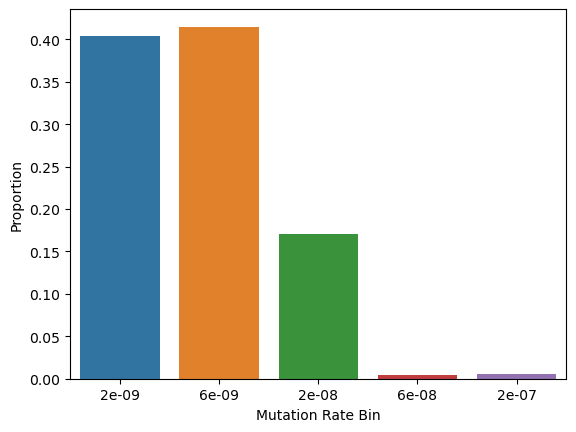

In [6]:
g = sns.barplot(df_proportions, x="mu_bin", y="prop")
g.set(xlabel="Mutation Rate Bin", ylabel="Proportion")
plt.savefig("mu_distribution.svg", format="svg", bbox_inches="tight")

# Define Class to Calculate Power

In [3]:
output_dir = "/home/djl34/kl_git/results"

@dataclass
class SFS_reader:
    selection: float
    mu_index: int
    bin_number: int
    window_length: int
    sample_size: int
    neutral_proportion: float = 0.0
    hypermutable_count: int = 0

    def get_multiple_sfs(self):
        
        list_sfs = [self.get_sfs() for i in range(self.sample_size)]
        return list_sfs
    
    def get_sfs(self) -> np.ndarray:
    
        #for mu_index == -1, use the empirical distribution of mu
        if self.mu_index == -1:
            # first = True
    
            #sample mu
            df_sample = df_proportions.sample(n = self.window_length, replace = True, weights = "prop")
            df_sample = pd.DataFrame(df_sample.groupby("mu_bin").size()).reset_index()

            rows = [self.get_sfs4mu(mu, df_sample) for mu in mu_list]
            neutral_sfs_all = np.concatenate([row[0] for row in rows], axis=0)
            data_array_all = np.concatenate([row[1] for row in rows], axis=0)
          
        else:
            mu = mu_list[self.mu_index]
            neutral_sfs_all, data_array_all = self.generate_neutral_observed_sfs(self.window_length, mu)
            
        multiSFS = mlr.multiSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)

        return multiSFS
        
    def get_sfs4mu(self, mu, df_sample) -> float:
        #find length to generate
        length = df_sample[df_sample["mu_bin"] == mu][0].item()

        #depend on hypermutable count
        if math.isclose(mu, 2.0e-07, rel_tol=1e-9, abs_tol=0.0):
            length += self.hypermutable_count

        return self.generate_neutral_observed_sfs(length, mu)

    def generate_neutral_observed_sfs(self, length, mu) -> (np.ndarray, np.ndarray):
        file_prefix = "SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__"
        filename = os.path.join(output_dir, f"{file_prefix}-{self.selection}_mu_{mu}_bin_{self.bin_number}.npy")
        neutral_filename = os.path.join(output_dir, f"{file_prefix}-0.0_mu_{mu}_bin_{self.bin_number}.npy")
    
        sfs_array = np.load(filename)
        neutral_sfs = np.load(neutral_filename)
    
        #some mixture of neutral sites with certain proportions
        if self.neutral_proportion:
            #sample from bernoulli distribution with p = neutral_proportion
            neutral_length = np.random.binomial(n=length, p= self.neutral_proportion)
            non_neutral_length = length - neutral_length
    
            data_array = np.random.multinomial(non_neutral_length, sfs_array)[None, ...]
            neutral_data_array = np.random.multinomial(neutral_length, neutral_sfs)[None, ...]
            data_array += neutral_data_array
            
        else:
            data_array = np.random.multinomial(length, sfs_array)[None, ...]
        
        return neutral_sfs[None, ...], data_array

In [4]:
@dataclass
class Power_Calculator:
    sfs: list
    # selection: float
    # mu_index: int
    # bin_number: int
    # sample_size: int
    transformation: str = "none"
    z_score_cutoff: float = 2.0
    type: str = "cdf"
    reverse: bool = False
    
    def calculate_power(self) -> (float, list):

        sample_size = len(self.sfs)
        
        list_zscore = [self.get_score(i) for i in range(sample_size)]
        
        return sum(np.array(list_zscore) > self.z_score_cutoff)/sample_size, list_zscore

    def get_score(self, iterator) -> float:
    
        sfs_test = self.sfs[iterator]
        
        if self.type == "Gnocchi":
            return sfs_test.gnocchi()
        elif self.type == "ExtraINSIGHT":
            return sfs_test.extrainsight()
        elif self.type == "binarized":
            return sfs_test.zscore_binarized(reverse = self.reverse)[0]
        elif self.type == "cdf":
            return sfs_test.zscore_cdf(transformation = self.transformation, reverse = self.reverse)[0]
        elif self.type == "cdf flipped":
            return (sfs_test.zscore_cdf(transformation = self.transformation, reverse = False)[0] + 
             sfs_test.zscore_cdf(transformation = self.transformation, reverse = True)[0])/2
        elif self.type == "cdf combined":
            return (sfs_test.zscore_cdf(transformation = "none", reverse = False)[0] + 
             sfs_test.zscore_cdf(transformation = "log", reverse = True)[0])/2
        elif self.type == "cdf zero":
            return sfs_test.zscore_cdf(transformation = self.transformation, reverse = self.reverse, zero_bin = True)[0]
            
    def get_method_name(self):
        if (self.type == "Gnocchi"):
            output_string = "Poisson"
        elif ((self.type == "ExtraINSIGHT") | (self.type == "binarized") | (self.type == "cdf flipped") 
        | (self.type == "cdf combined")): 
            output_string = self.type
        else:
            if self.transformation == "none":
                output_string = f"sum(p)"
            elif self.transformation == "log":
                output_string = f"sum(log(p))"

        if self.reverse:
            output_string += " reverse"
        if self.type == "cdf zero":
            output_string += " zero"

        return output_string

# Z score distribution plot

In [6]:
selection_list = [0.0, 0.1, 0.01, 0.001]
window_length_list = [150]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = 2, window_length = window_length,
                              sample_size = 1000)
                  for window_length in window_length_list for selection in selection_list]
sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]

method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "Gnocchi") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "binarized") for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_2 = pd.DataFrame(zip(zscore_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = [ "zscore", "selection", "window length", "method", "power"])

df_zscore_2 = df_2.explode("zscore")

In [7]:
selection_list = [0.0, 0.1, 0.01, 0.001]
window_length_list = [150]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = 9, window_length = window_length,
                              sample_size = 1000)
                  for window_length in window_length_list for selection in selection_list]
sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]

method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])


selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_9 = pd.DataFrame(zip(zscore_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = [ "zscore", "selection", "window length", "method", "power"])

df_zscore_9 = df_9.explode("zscore")

In [8]:
df_zscore = pd.concat([df_zscore_2, df_zscore_9])

/tmp/ipykernel_29478/1679862209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zscore_plot["method"] = df_zscore_plot["method"].replace("sum(log(p)) reverse", r"$\sum{log(p_{reverse})}$")
/tmp/ipykernel_29478/1679862209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zscore_plot["method"] = df_zscore_plot["method"].replace("sum(p)", r"$\sum{p}$")
/tmp/ipykernel_29478/1679862209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

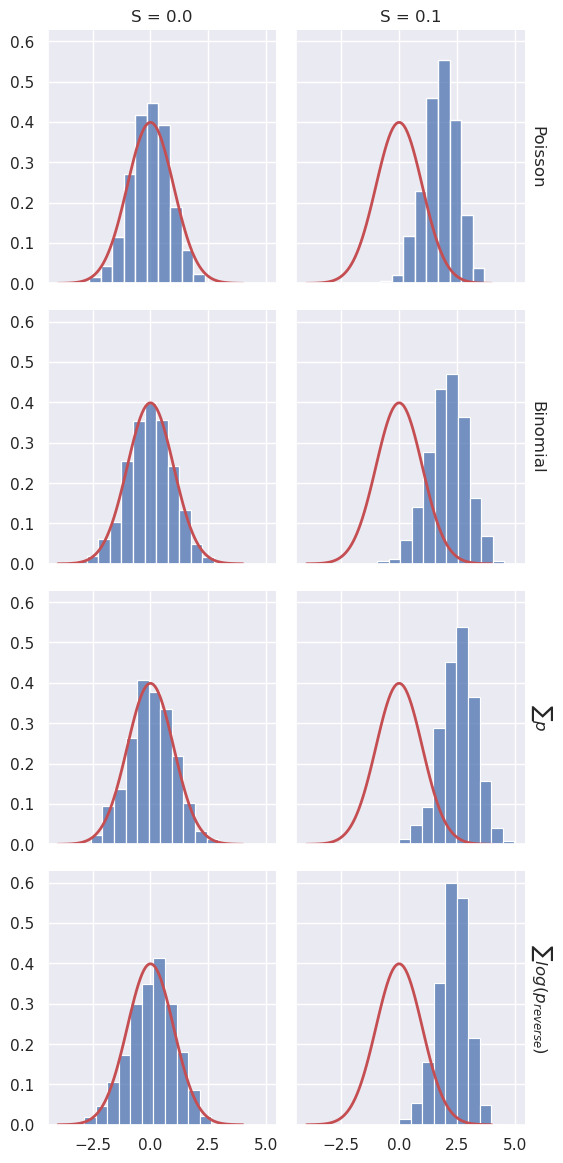

In [9]:
sns.set_theme(style="darkgrid")

df_zscore_plot = df_zscore[(df_zscore["selection"].isin([0.0, 0.1])) & (df_zscore["window length"] == 150)]
df_zscore_plot["method"] = df_zscore_plot["method"].replace("sum(log(p)) reverse", r"$\sum{log(p_{reverse})}$")
df_zscore_plot["method"] = df_zscore_plot["method"].replace("sum(p)", r"$\sum{p}$")
df_zscore_plot["method"] = df_zscore_plot["method"].replace("binarized", "Binomial")

g = sns.FacetGrid(df_zscore_plot, col="selection", row="method", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S = {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Distribution of Scores')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)
g.set(xlabel=None, ylabel=None)

plt.savefig("2a.svg", format="svg", bbox_inches="tight")

# Power Plot

In [16]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [150, 500, 1500]
bin_number_list = [2]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = bin_number, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list for bin_number in bin_number_list]

sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]
bin_number_rows = [sfs_reader.bin_number for sfs_reader in sfs_reader_rows]

method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "binarized") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "Gnocchi") for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
bin_number_rows = bin_number_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_2 = pd.DataFrame(zip(zscore_rows, selection_rows, bin_number_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "bin number", "window length", "method", "power"])

df_zscore_2 = df_2.explode("zscore")

In [13]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [150, 500, 1500]
bin_number_list = [9]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = bin_number, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list for bin_number in bin_number_list]

sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]
bin_number_rows = [sfs_reader.bin_number for sfs_reader in sfs_reader_rows]

method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
bin_number_rows = bin_number_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_9 = pd.DataFrame(zip(zscore_rows, selection_rows, bin_number_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "bin number", "window length", "method", "power"])

df_zscore_9 = df_9.explode("zscore")

In [17]:
df_2_9 = pd.concat([df_2, df_9])

<Figure size 700x400 with 0 Axes>

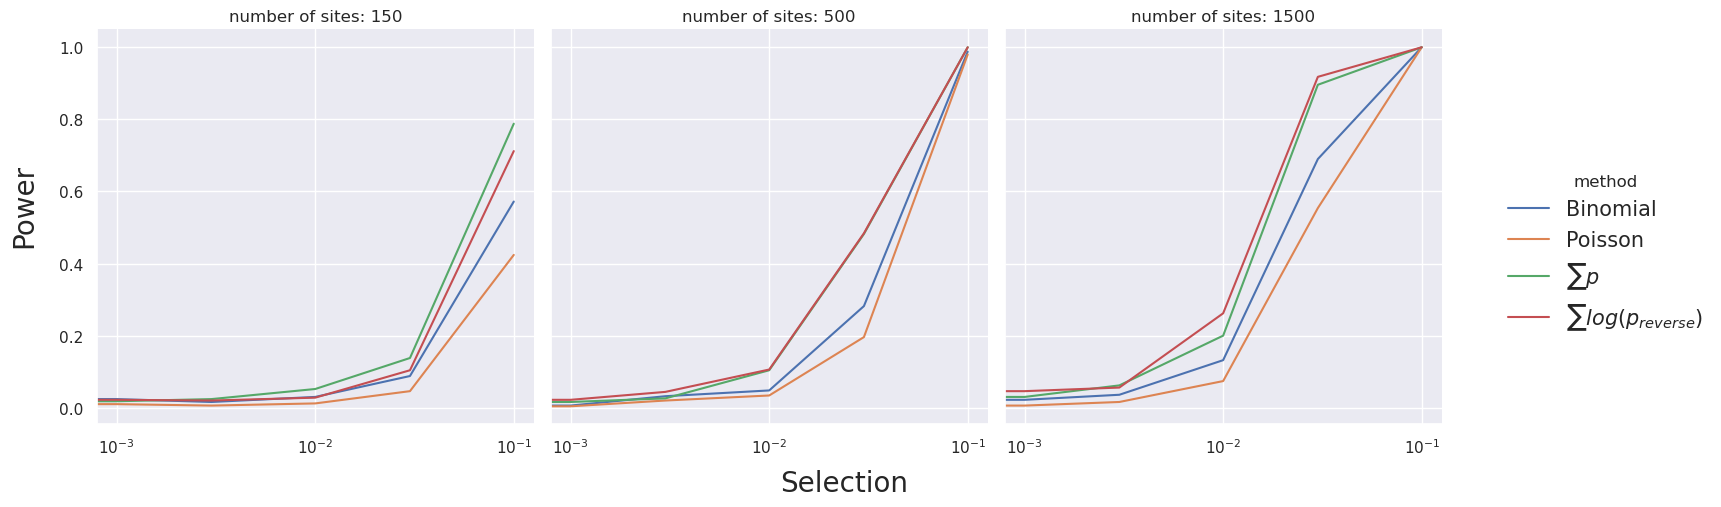

In [27]:
sns.set_theme(style="darkgrid")

df_plot = df_2_9.copy()
df_plot["method"] = df_plot["method"].replace("sum(log(p)) reverse", r"$\sum{log(p_{reverse})}$")
df_plot["method"] = df_plot["method"].replace("sum(p)", r"$\sum{p}$")
df_plot["method"] = df_plot["method"].replace("binarized", "Binomial")

plt.figure(figsize=(7, 4))

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="number of sites: {col_name}", row_template="mu: {row_name}")
g.set(xscale="log")
g.add_legend(fontsize = '15')

g.set(xlabel=None, ylabel=None)
g.fig.text(0.45, 0, "Selection", size = 20)
g.fig.text(0, 0.5, "Power", size = 20, rotation = 90)
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_windowlength_9bins_versus_binarized.svg", format="svg", bbox_inches="tight")

# Analysis: Compare Within Binary SFS

Do over realistic mutation rate distribution

In [5]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [50, 150, 500, 1500]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = 2, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list]
sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]

In [14]:
method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "Gnocchi") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "binarized") for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "binarized", reverse = True) for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf", reverse = True) for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log") for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(zscore_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = [ "zscore", "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

In [15]:
df_zscore["method"].unique()

array(['Poisson', 'binarized'], dtype=object)

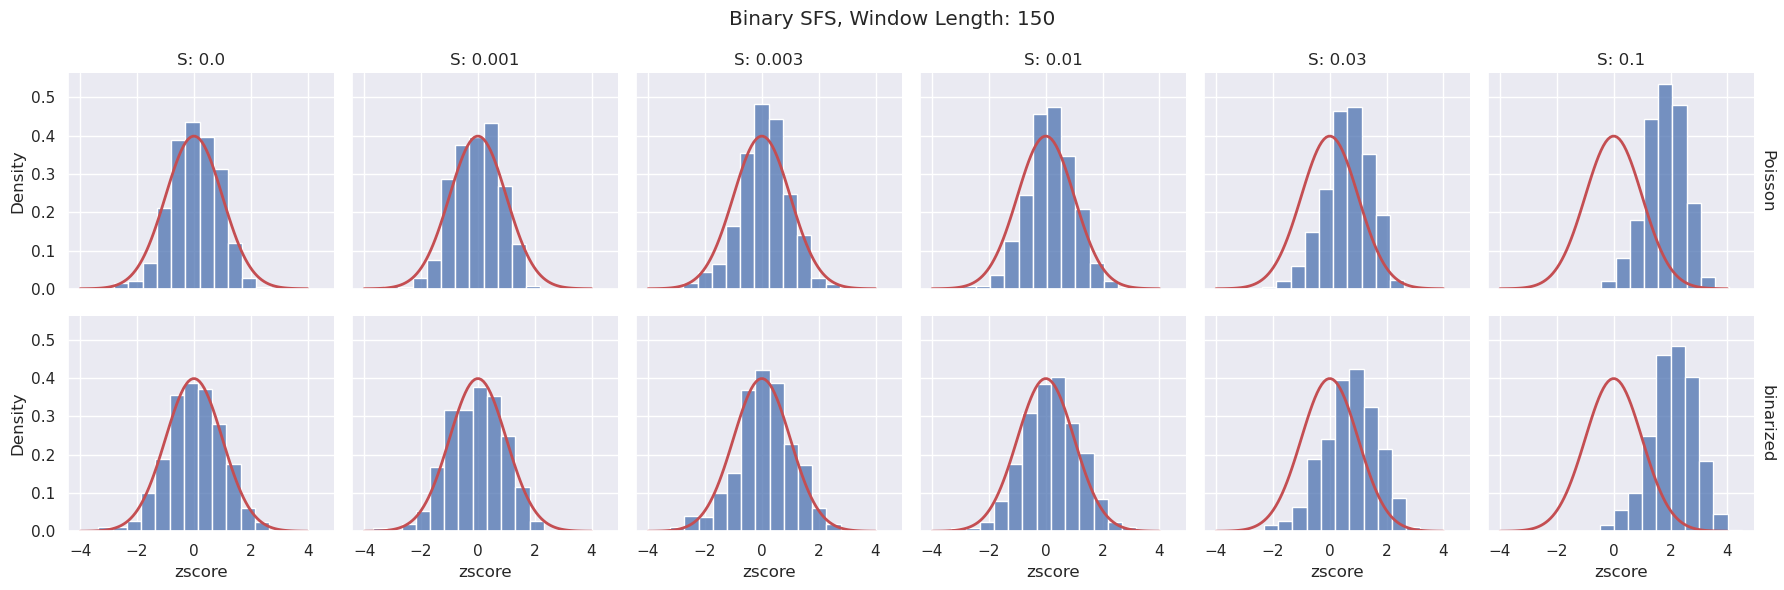

In [16]:
sns.set_theme(style="darkgrid")

df_zscore_plot = df_zscore[df_zscore["window length"] == 150]

g = sns.FacetGrid(df_zscore_plot, col="selection", row="method", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Binary SFS, Window Length: 150')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

plt.savefig("standard_score_binary_zscore_plot.svg", format="svg", bbox_inches="tight")

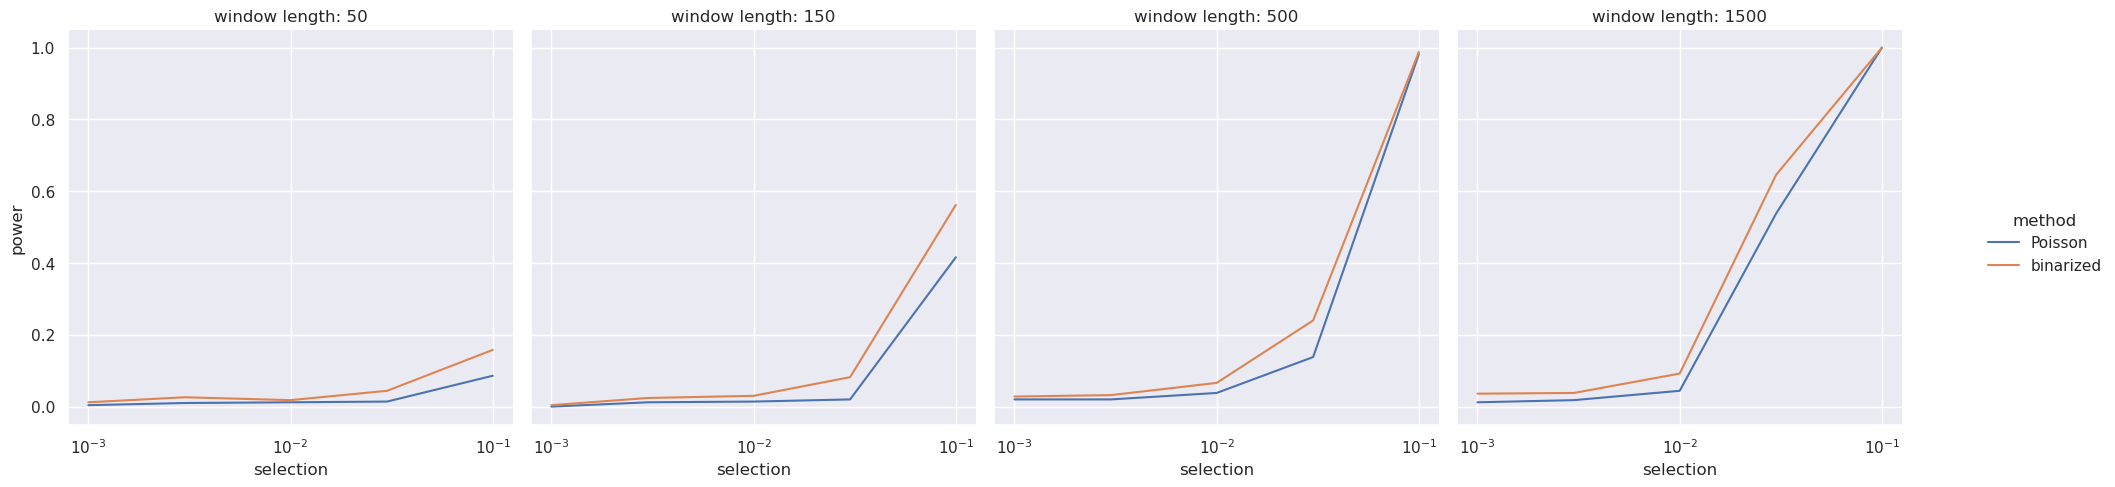

In [17]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()
df_plot = df[df["selection"] != 0.0]

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength_binary.svg", format="svg", bbox_inches="tight")

# Analysis: Compare within 9 bins

## mu distribution

In [59]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [50, 150, 500, 1500]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = 9, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list]
sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]

### first compare cdf for reverse, log

In [61]:
method_number = 5

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", reverse = True) for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf flipped") for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf zero") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(zscore_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

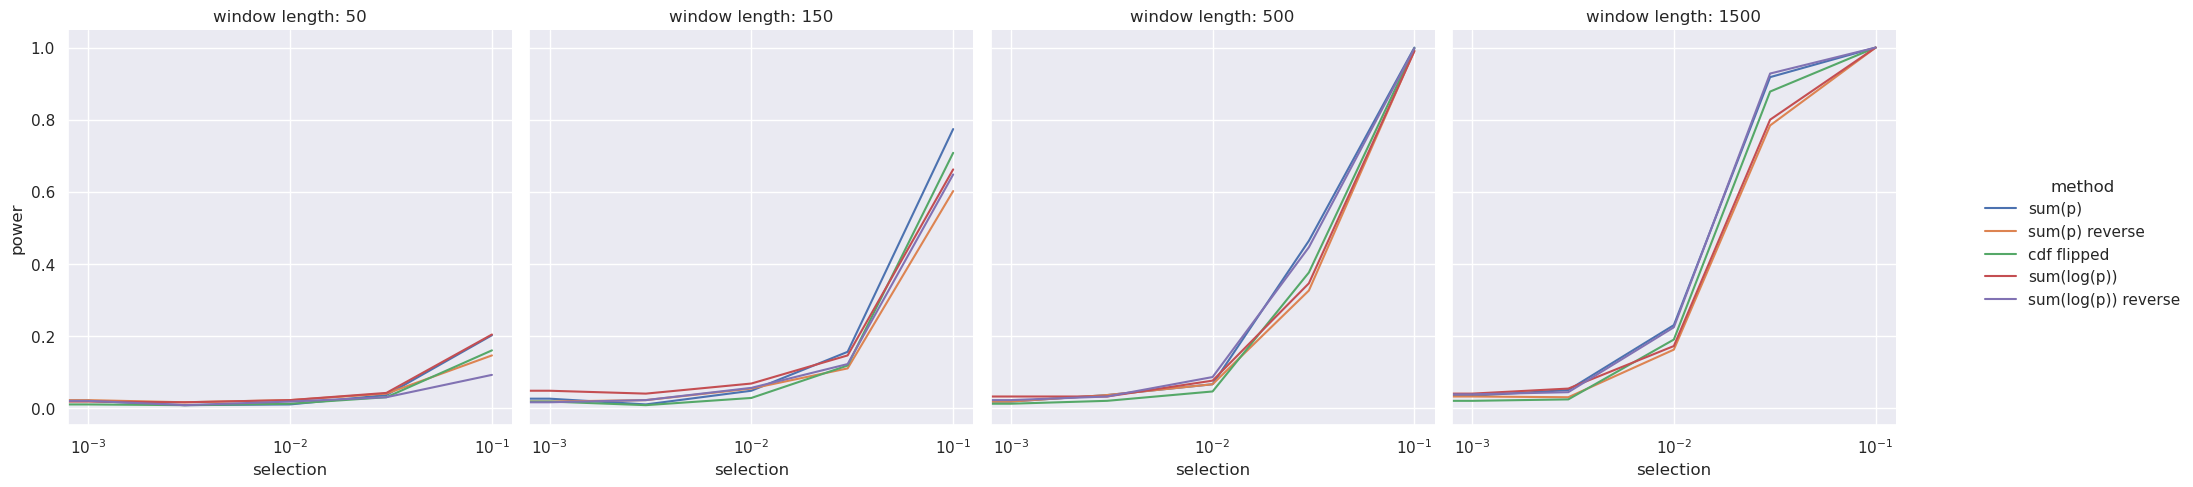

In [62]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_windowlength_9bins.svg", format="svg", bbox_inches="tight")

### then compare with zero_bin on

In [63]:
method_number = 4

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf flipped") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf zero") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(zscore_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

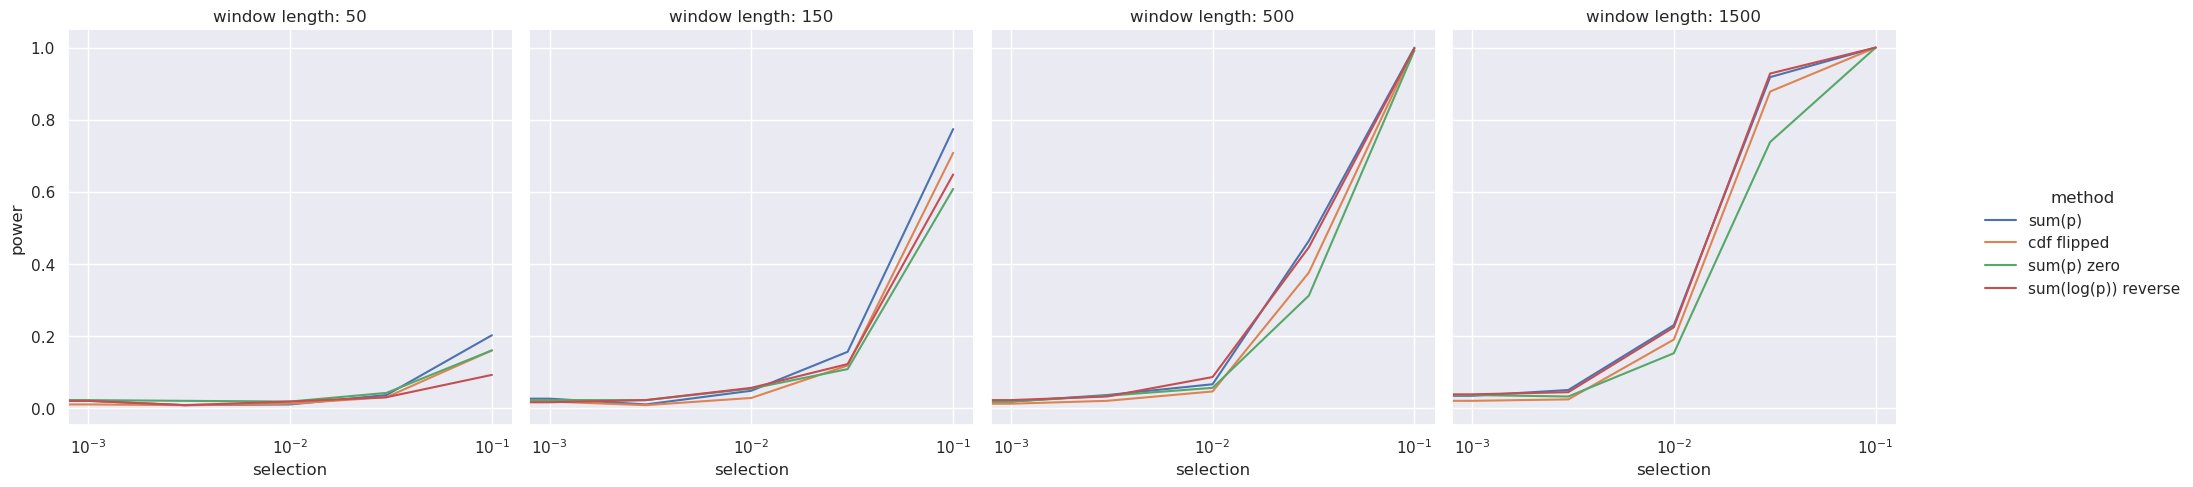

In [64]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_windowlength_zerobin_9bins.svg", format="svg", bbox_inches="tight")

## for various mu bins

In [85]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [50, 150, 500, 1500]
mu_index_list = list(range(5))

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = mu_index, bin_number = 9, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list for mu_index in mu_index_list]
sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]
mu_rows = [df_proportions.iloc[sfs_reader.mu_index]["mu_bin"].item() for sfs_reader in sfs_reader_rows]

### first compare cdf for reverse, log

In [ ]:
method_number = 5

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", reverse = True) for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf flipped") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
mu_rows = mu_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

In [54]:
df = pd.DataFrame(zip(zscore_rows, mu_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "mu",  "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

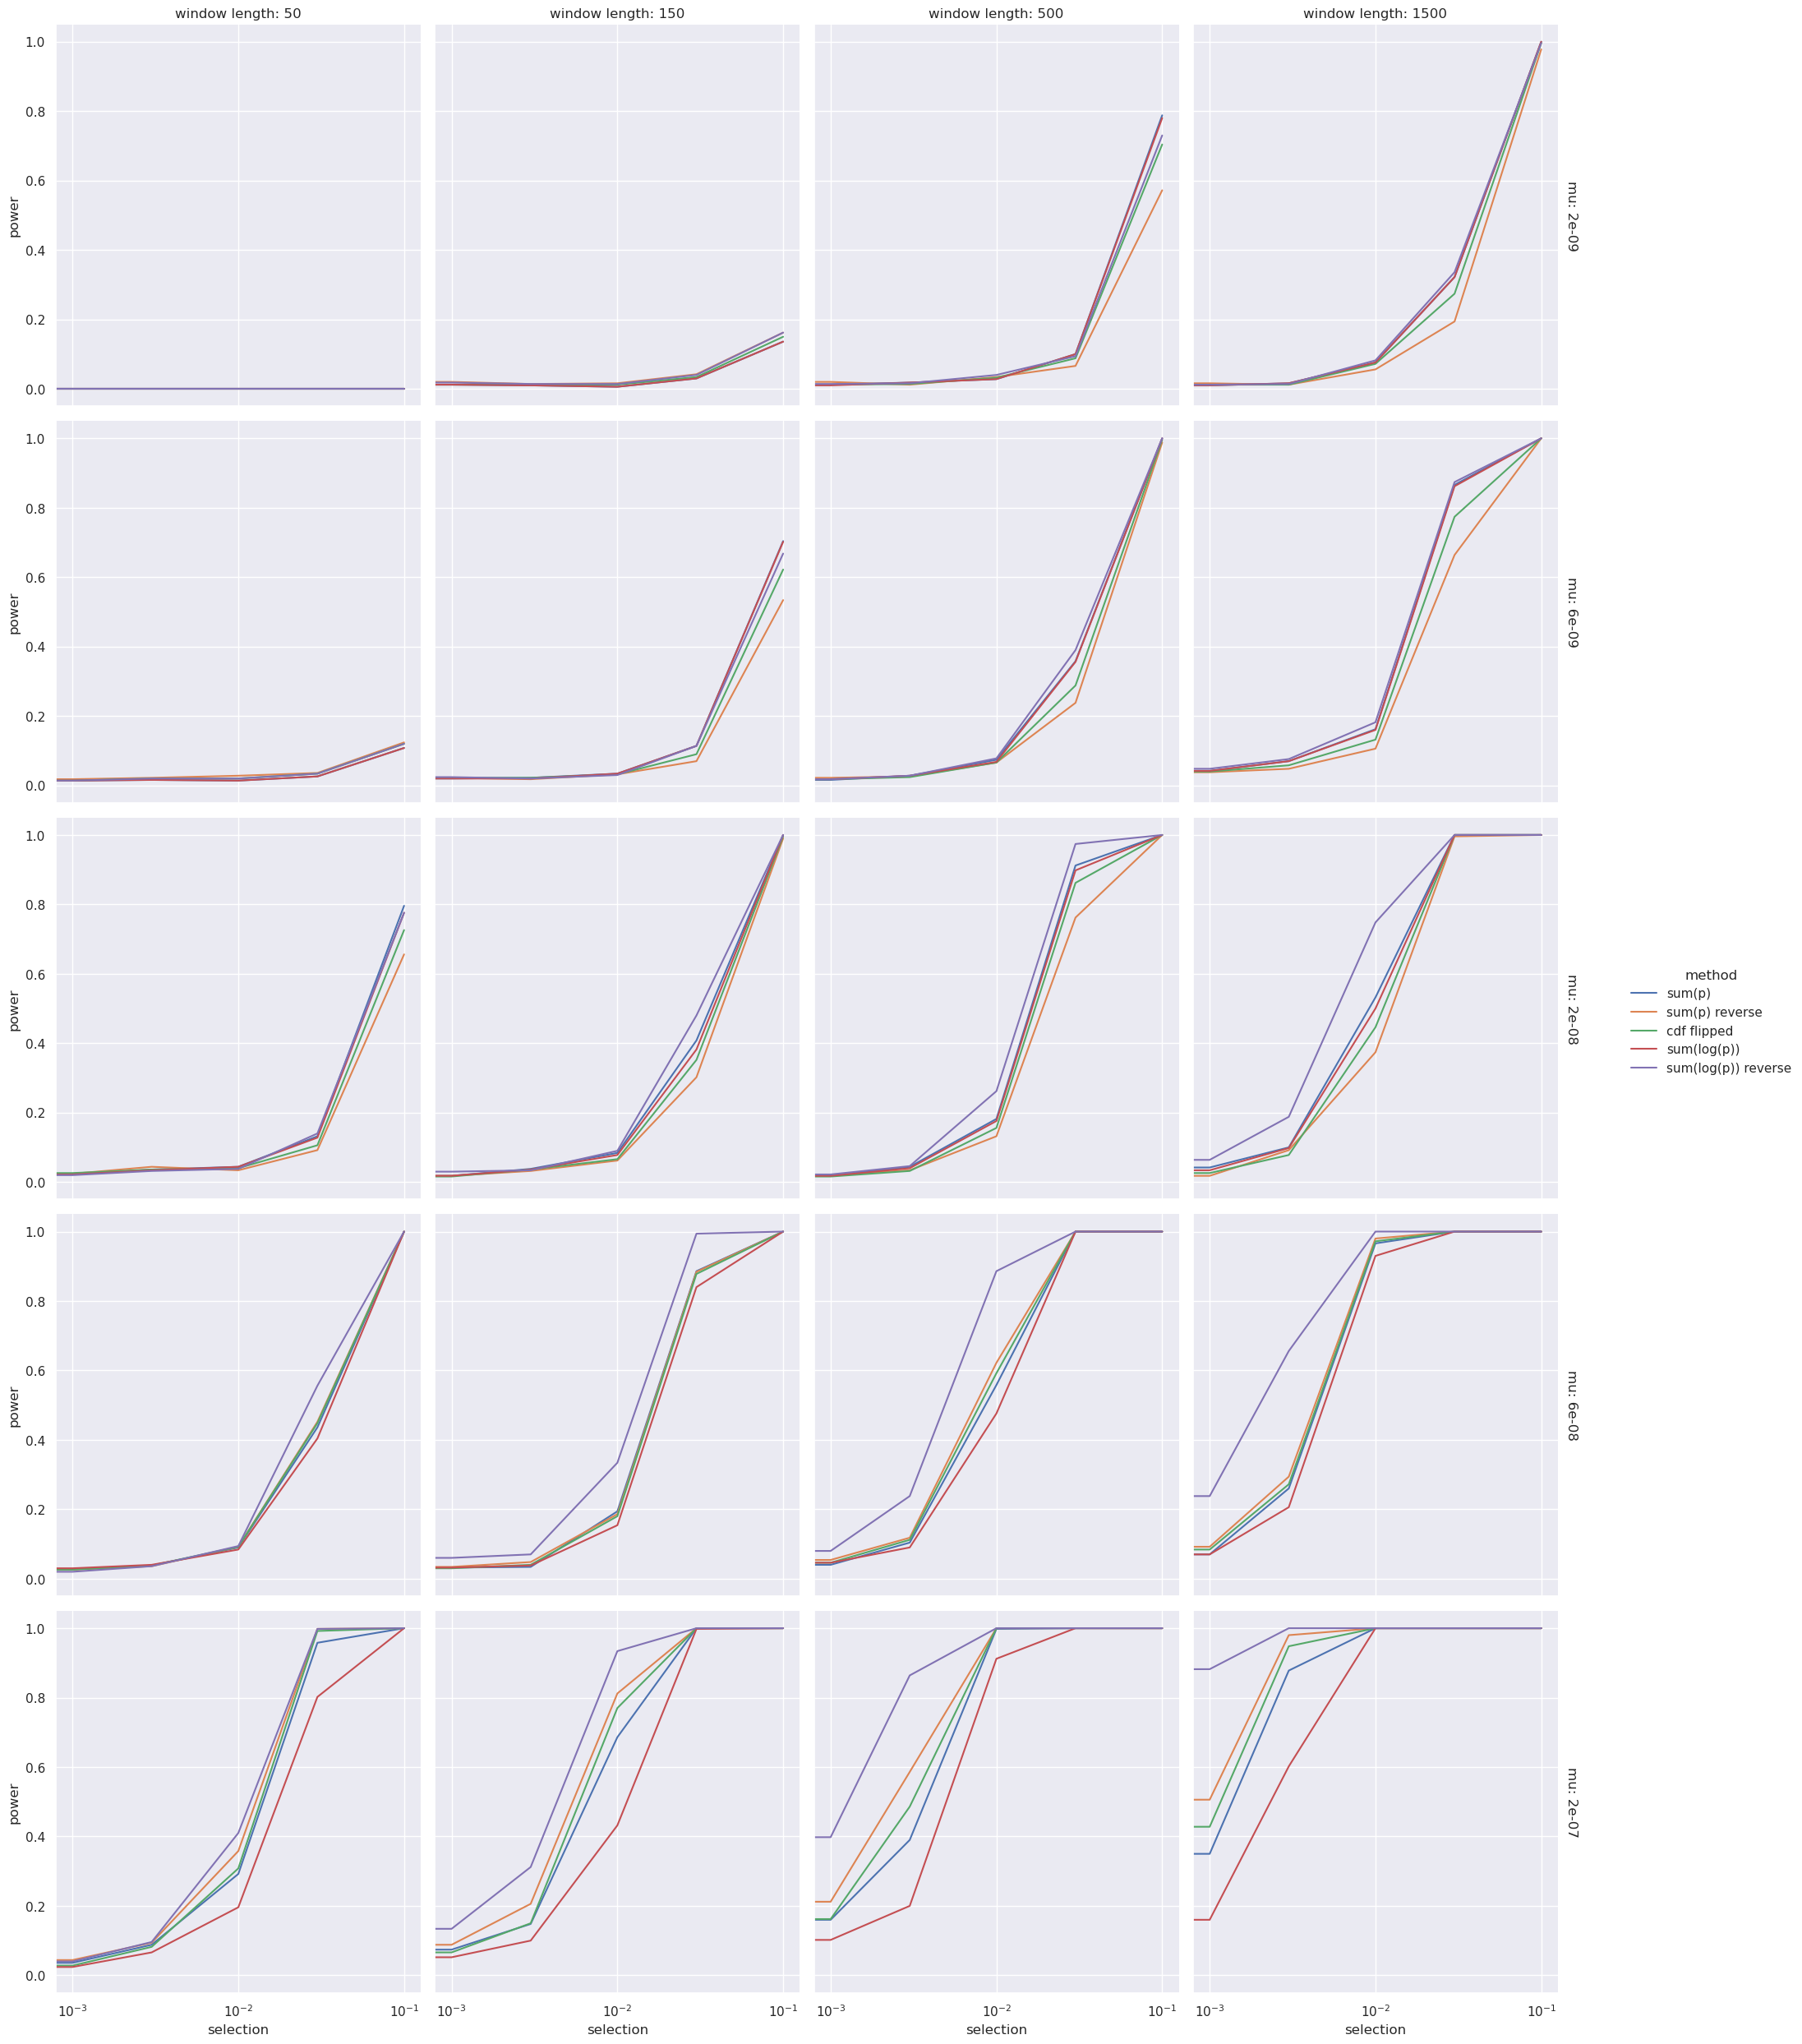

In [58]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", row = "mu", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="mu: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength_9bins.svg", format="svg", bbox_inches="tight")

### with zero_bin on

In [66]:
method_number = 4

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf flipped") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf zero") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
mu_rows = mu_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(zscore_rows, mu_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "mu",  "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

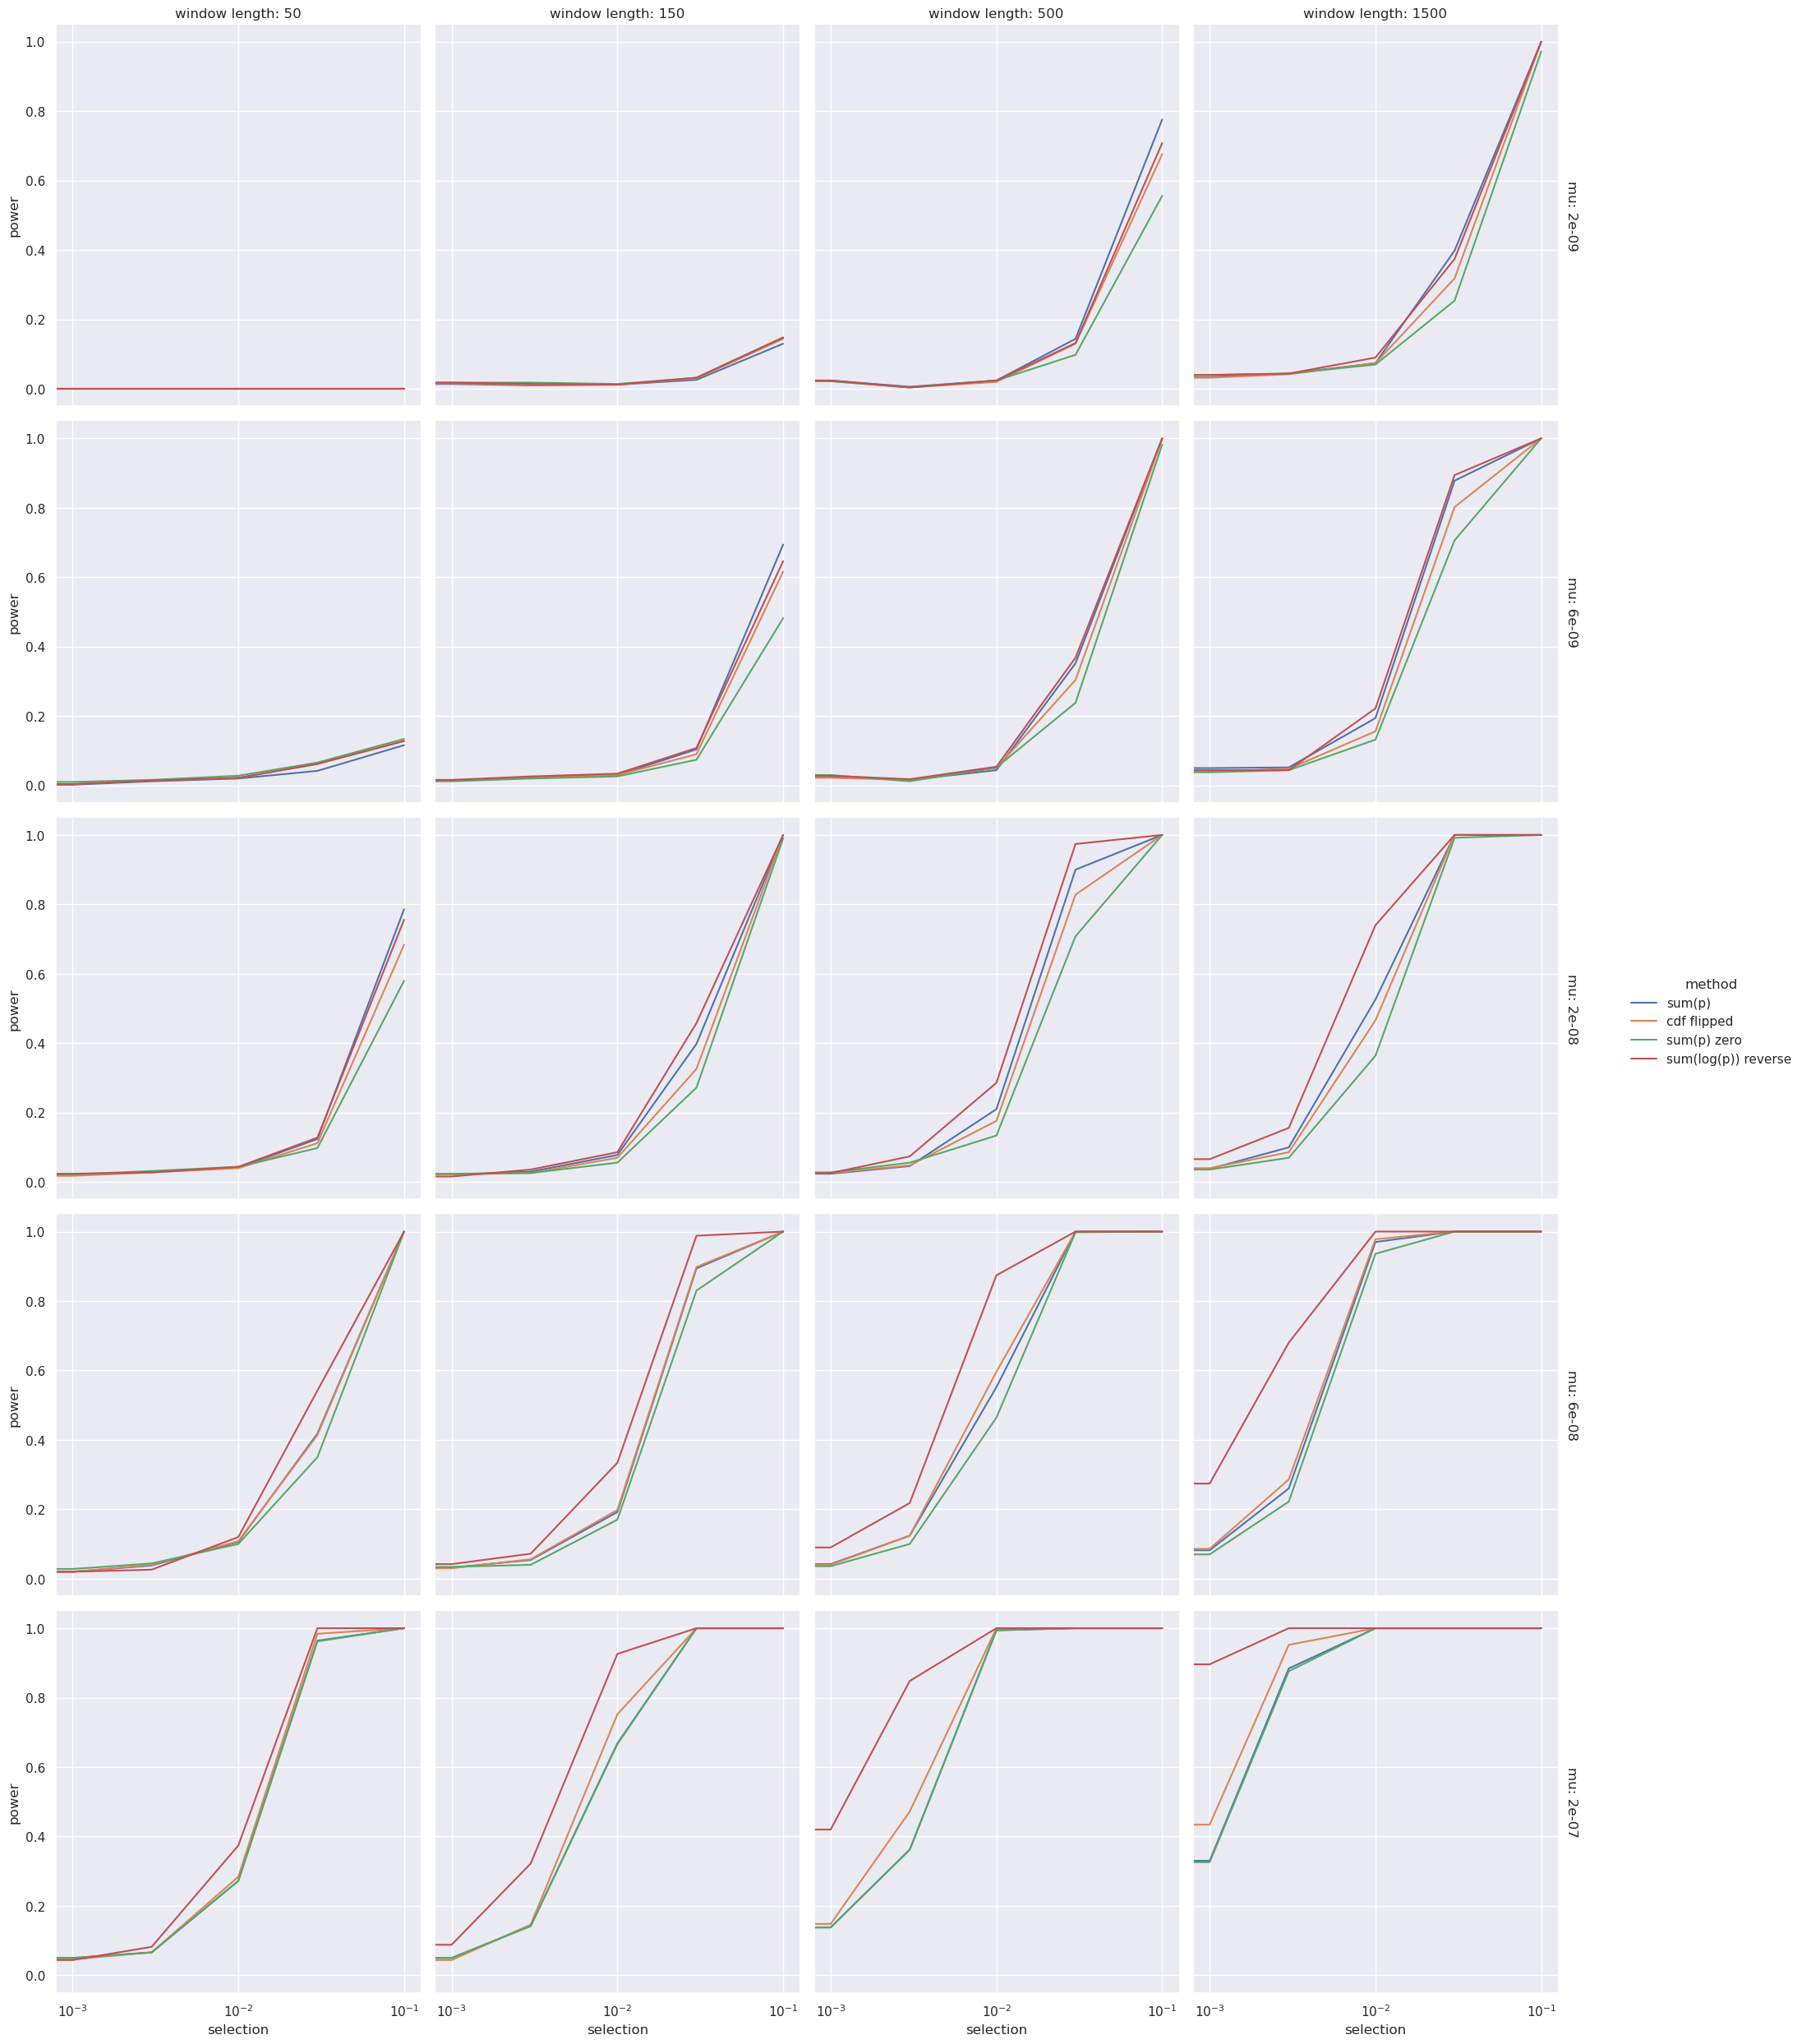

In [67]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", row = "mu", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="mu: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
# plt.savefig("power_analysis_mu_windowlength_9bins.svg", format="svg", bbox_inches="tight")

### try combining sum(p) and sum(log(p)) reverse

In [88]:
method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf flipped") for sfs in sfs_rows])
# calculator_rows.extend([Power_Calculator(sfs, type = "cdf combined") for sfs in sfs_rows])
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
mu_rows = mu_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(zscore_rows, mu_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "mu",  "selection", "window length", "method", "power"])

df_zscore = df.explode("zscore")

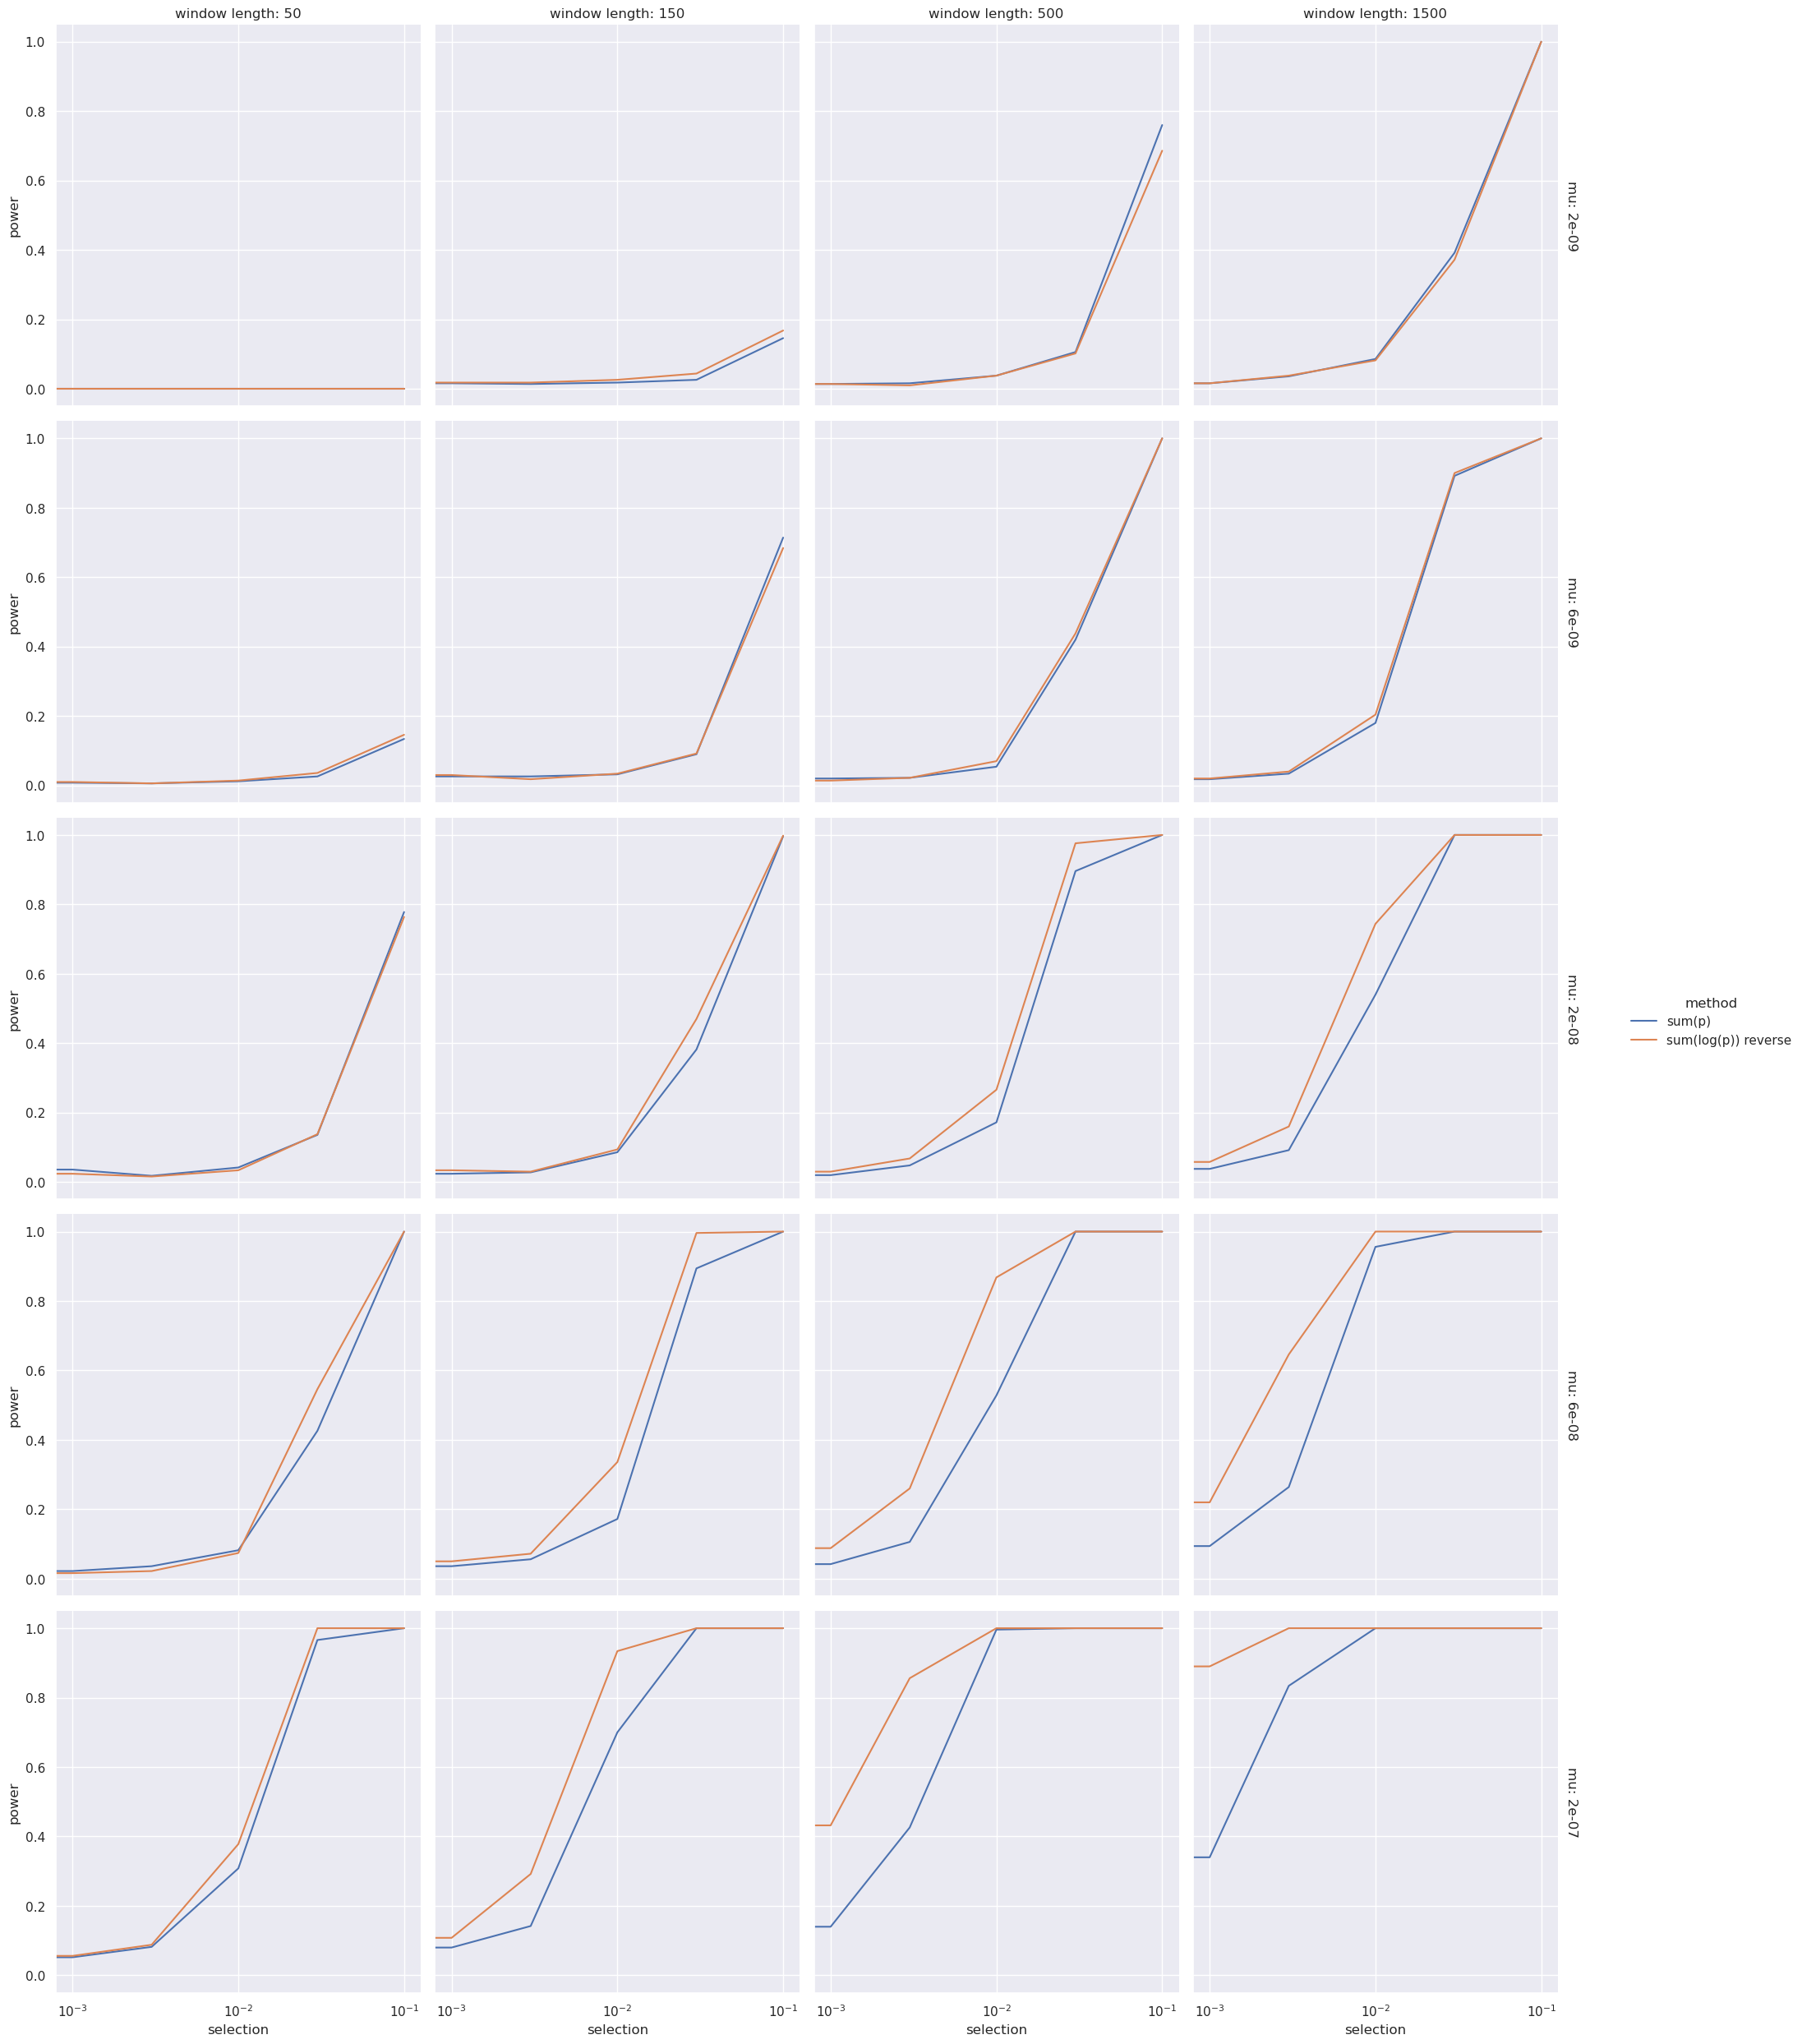

In [90]:
sns.set_theme(style="darkgrid")

df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", row = "mu", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="mu: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_sum_p_logpreverse_mu_windowlength_9bins.svg", format="svg", bbox_inches="tight")

# Analysis: Compare 9 bin vs binary

## for mutation rate distribution

In [24]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [150, 500, 1500]
bin_number_list = [2]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = bin_number, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list for bin_number in bin_number_list]

sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]
bin_number_rows = [sfs_reader.bin_number for sfs_reader in sfs_reader_rows]

method_number = 1

calculator_rows = [Power_Calculator(sfs, type = "binarized") for sfs in sfs_rows]
calculator_rows = [Power_Calculator(sfs, type = "binarized") for sfs in sfs_rows]

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
bin_number_rows = bin_number_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_2 = pd.DataFrame(zip(zscore_rows, selection_rows, bin_number_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "bin number", "window length", "method", "power"])

df_zscore_2 = df.explode("zscore")

KeyboardInterrupt: 

In [80]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [50, 150, 500, 1500]
bin_number_list = [9]
mu_index_list = [-1]

sfs_reader_rows = [SFS_reader(selection=selection, mu_index = -1, bin_number = bin_number, window_length = window_length,
                              sample_size = 500)
                  for window_length in window_length_list for selection in selection_list for bin_number in bin_number_list]

sfs_rows = [sfs_reader.get_multiple_sfs() for sfs_reader in sfs_reader_rows]

selection_rows = [sfs_reader.selection for sfs_reader in sfs_reader_rows]
window_length_rows = [sfs_reader.window_length for sfs_reader in sfs_reader_rows]
bin_number_rows = [sfs_reader.bin_number for sfs_reader in sfs_reader_rows]

method_number = 2

calculator_rows = [Power_Calculator(sfs, type = "cdf") for sfs in sfs_rows]
calculator_rows.extend([Power_Calculator(sfs, type = "cdf", transformation = "log", reverse = True) for sfs in sfs_rows])

selection_rows = selection_rows * method_number
window_length_rows = window_length_rows * method_number
bin_number_rows = bin_number_rows * method_number

method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df_9 = pd.DataFrame(zip(zscore_rows, selection_rows, bin_number_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["zscore", "selection", "bin number", "window length", "method", "power"])

df_zscore_9 = df.explode("zscore")

In [81]:
df_2_9 = pd.concat([df_2, df_9])

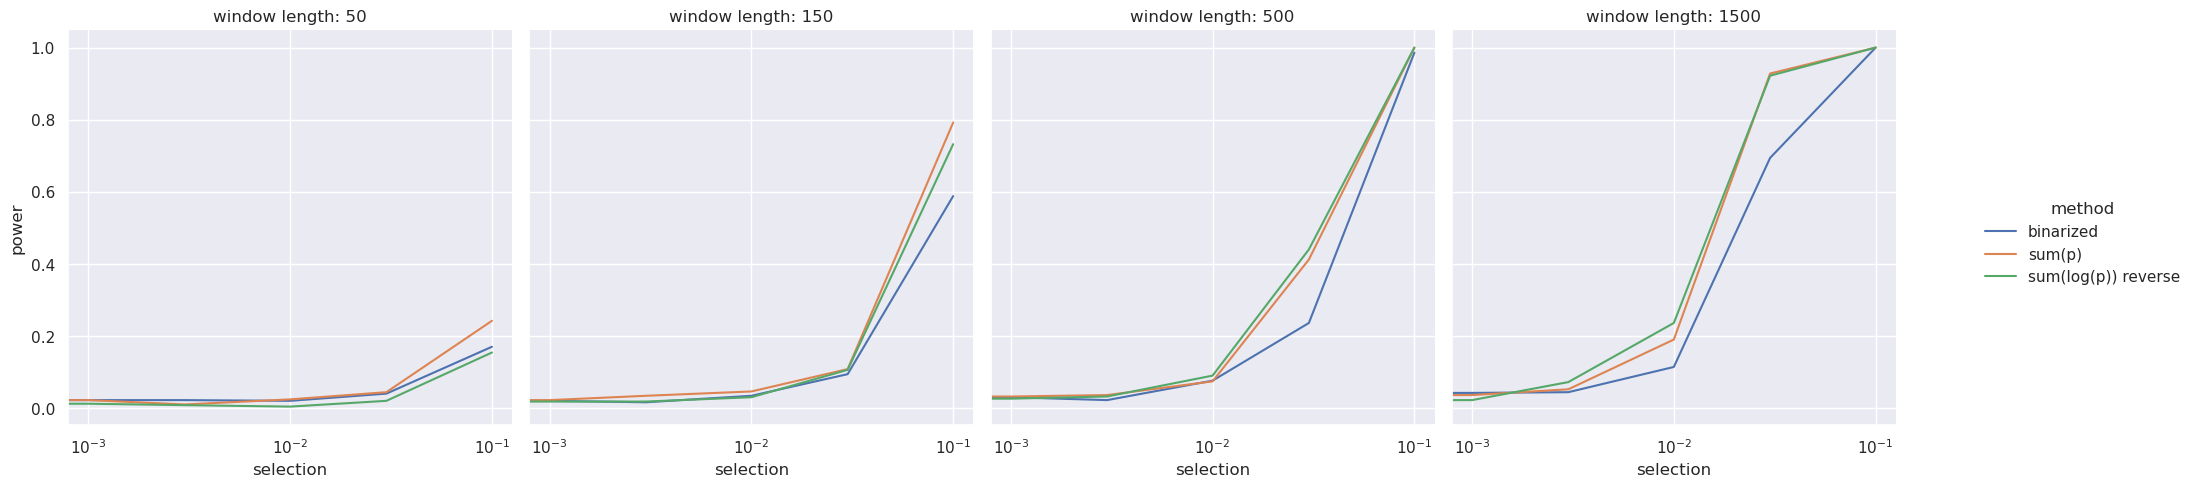

In [84]:
sns.set_theme(style="darkgrid")

df_plot = df_2_9.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="window length", height=5, margin_titles=True, hue = "method")
# g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="window length: {col_name}", row_template="mu: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_windowlength_9bins_versus_binarized.svg", format="svg", bbox_inches="tight")

## with hypermutable

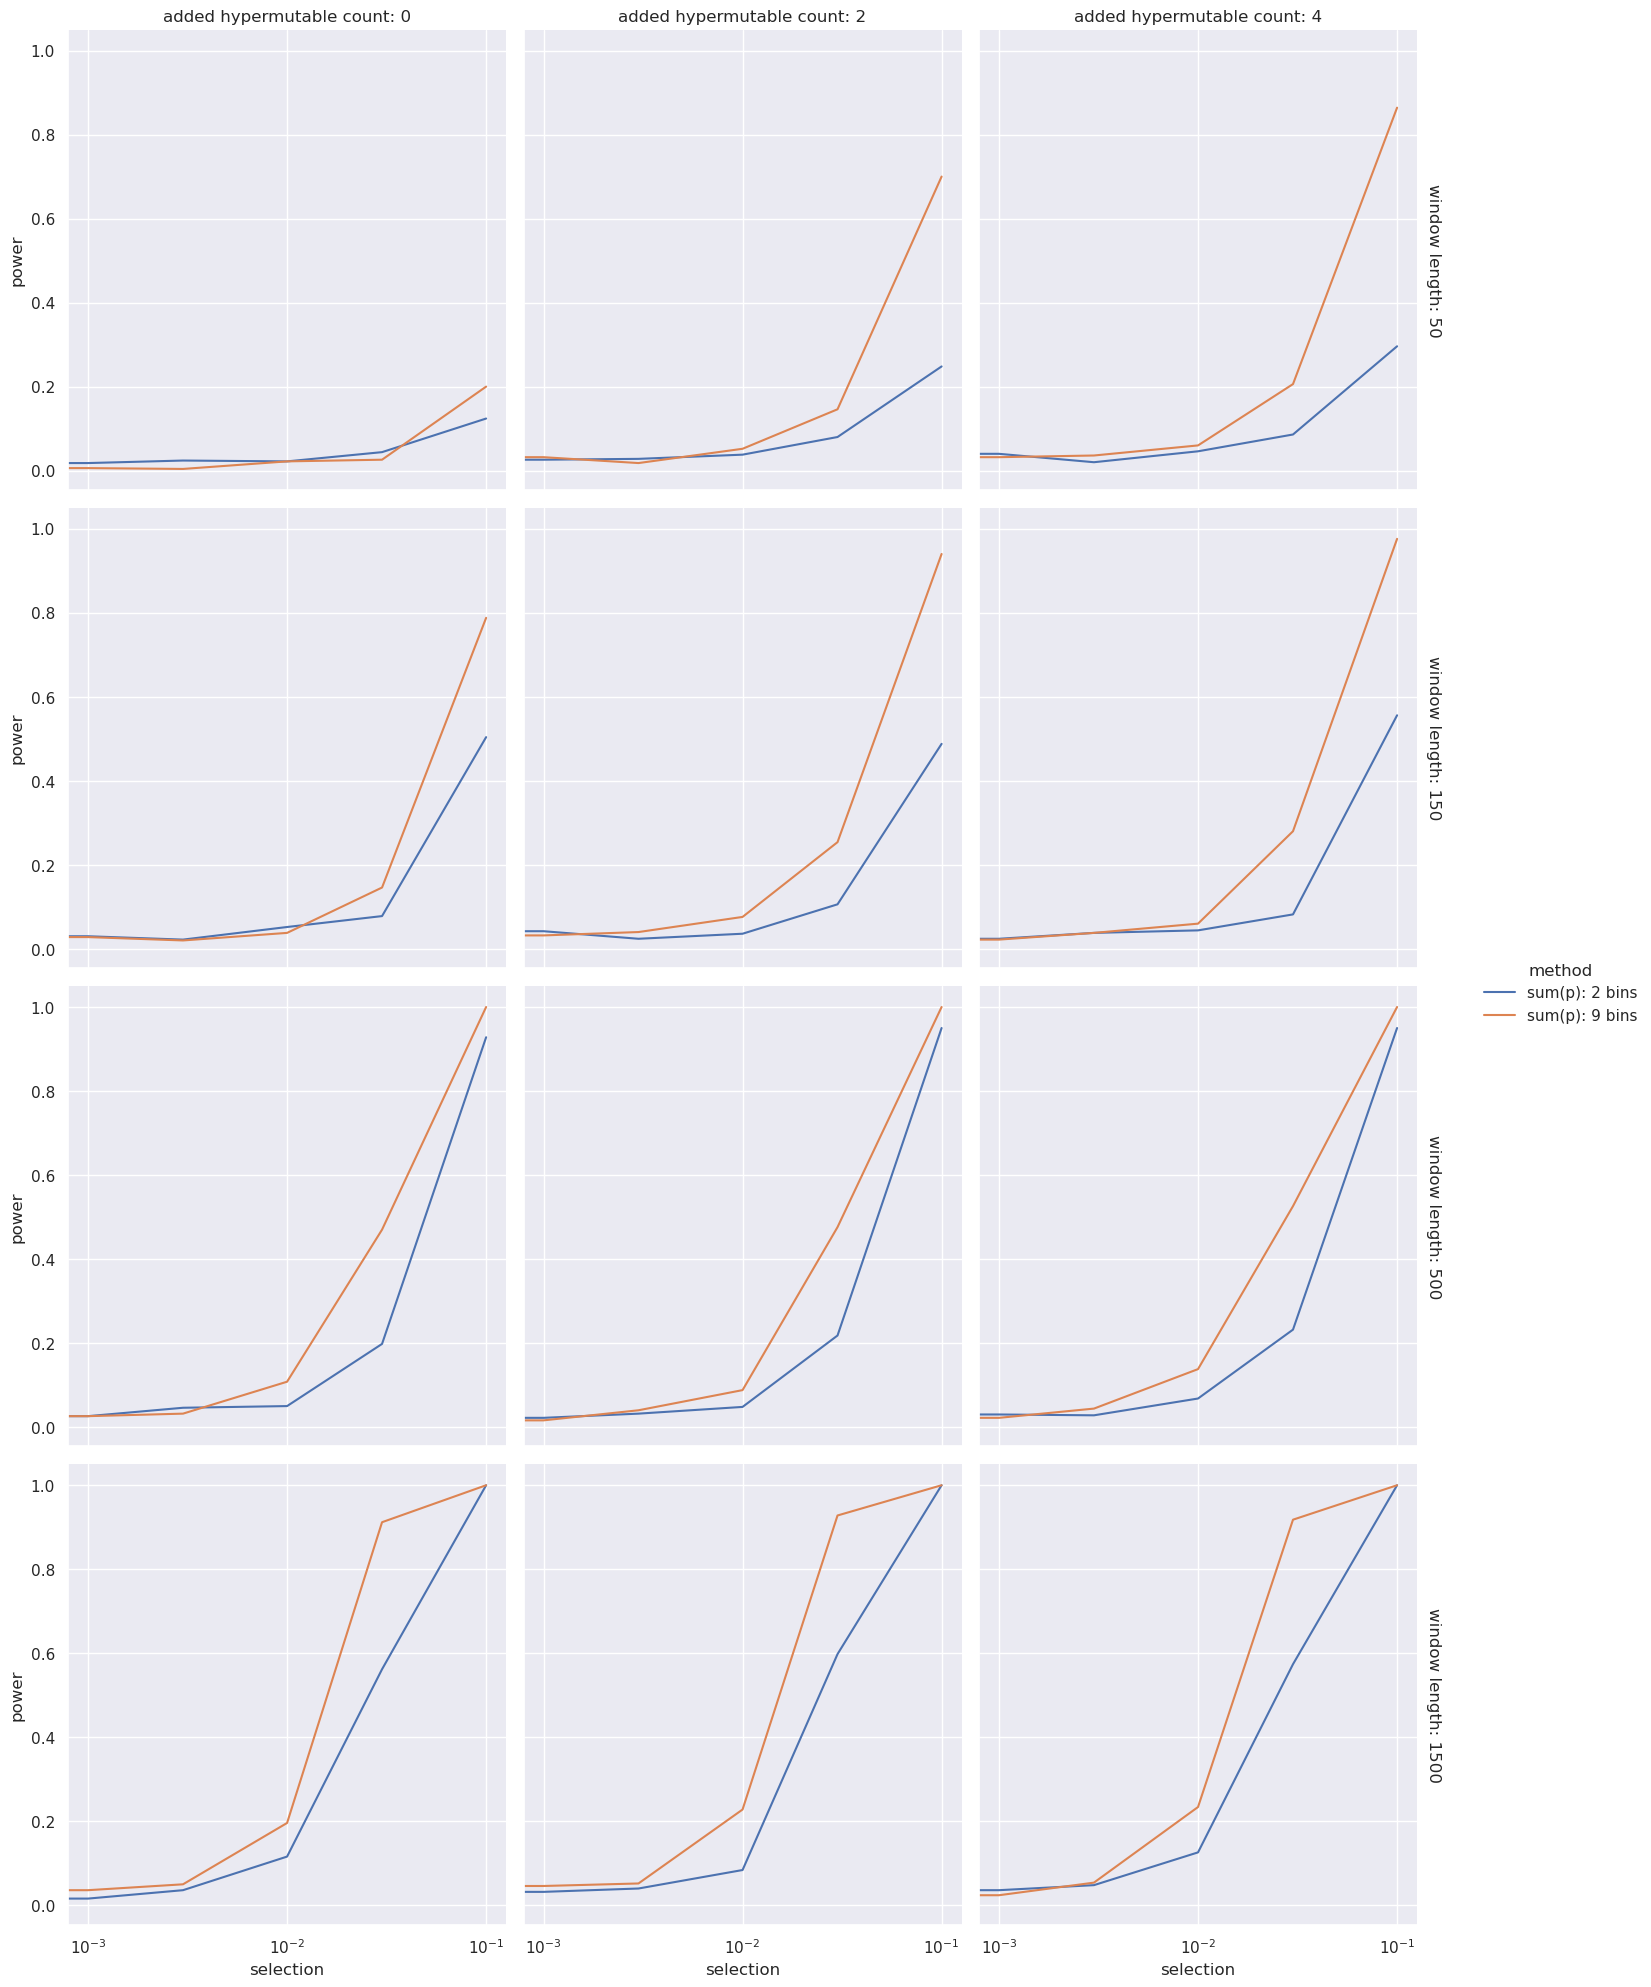

In [17]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
# df_plot = df[df["bin number"] == 2]
df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, row="window length", col = "hypermutable count", height=5, margin_titles=True, hue = "method")


g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="added hypermutable count: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
# plt.savefig("power_analysis_mu_windowlength.svg", format="svg", bbox_inches="tight")

## With at least two hypermutable sites

In [6]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [20, 100, 500, 2500] 
mu_index_list = [-1]
hypermutable_count_list = [0, 1, 2]

list_of_list_power = []
list_of_list_zscore = []

window_num = 500

for window_length in window_length_list:
    print(window_length)
    for selection in selection_list:
        print(selection)
        for mu_index in mu_index_list:
            for bin_num in [2, 9]:
                for hypermutable_count in hypermutable_count_list:
    
                    power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                         transformation = "log", mu_index = mu_index, hypermutable_count = hypermutable_count)
    
                    if mu_index == -1:
                        mu_name = "Empirical Distribution"
                    else:
                        mu_name = mu_list[mu_index]
                    
                    list_of_list_power.append([power, selection, mu_name, window_length, hypermutable_count, f"sum(log(p)): {bin_num} bins"])
                    for zscore in list_zscore:
                        list_of_list_zscore.append([zscore, selection, mu_name, window_length, hypermutable_count, f"sum(log(p)): {bin_num} bins"])
    
                    
                    power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                         transformation = "none", mu_index = mu_index, hypermutable_count = hypermutable_count)
                    list_of_list_power.append([power, selection, mu_name, window_length, hypermutable_count, f"sum(p): {bin_num} bins"])
                    for zscore in list_zscore:
                        list_of_list_zscore.append([zscore, selection, mu_name, window_length, hypermutable_count, f"sum(p): {bin_num} bins"])
        
df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "hypermutable_count", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length",  "hypermutable_count", "type"])

20
0.0
0.1
0.03
0.01
0.003
0.001
100
0.0
0.1
0.03
0.01
0.003
0.001
500
0.0
0.1
0.03
0.01
0.003
0.001
2500
0.0
0.1
0.03
0.01
0.003
0.001


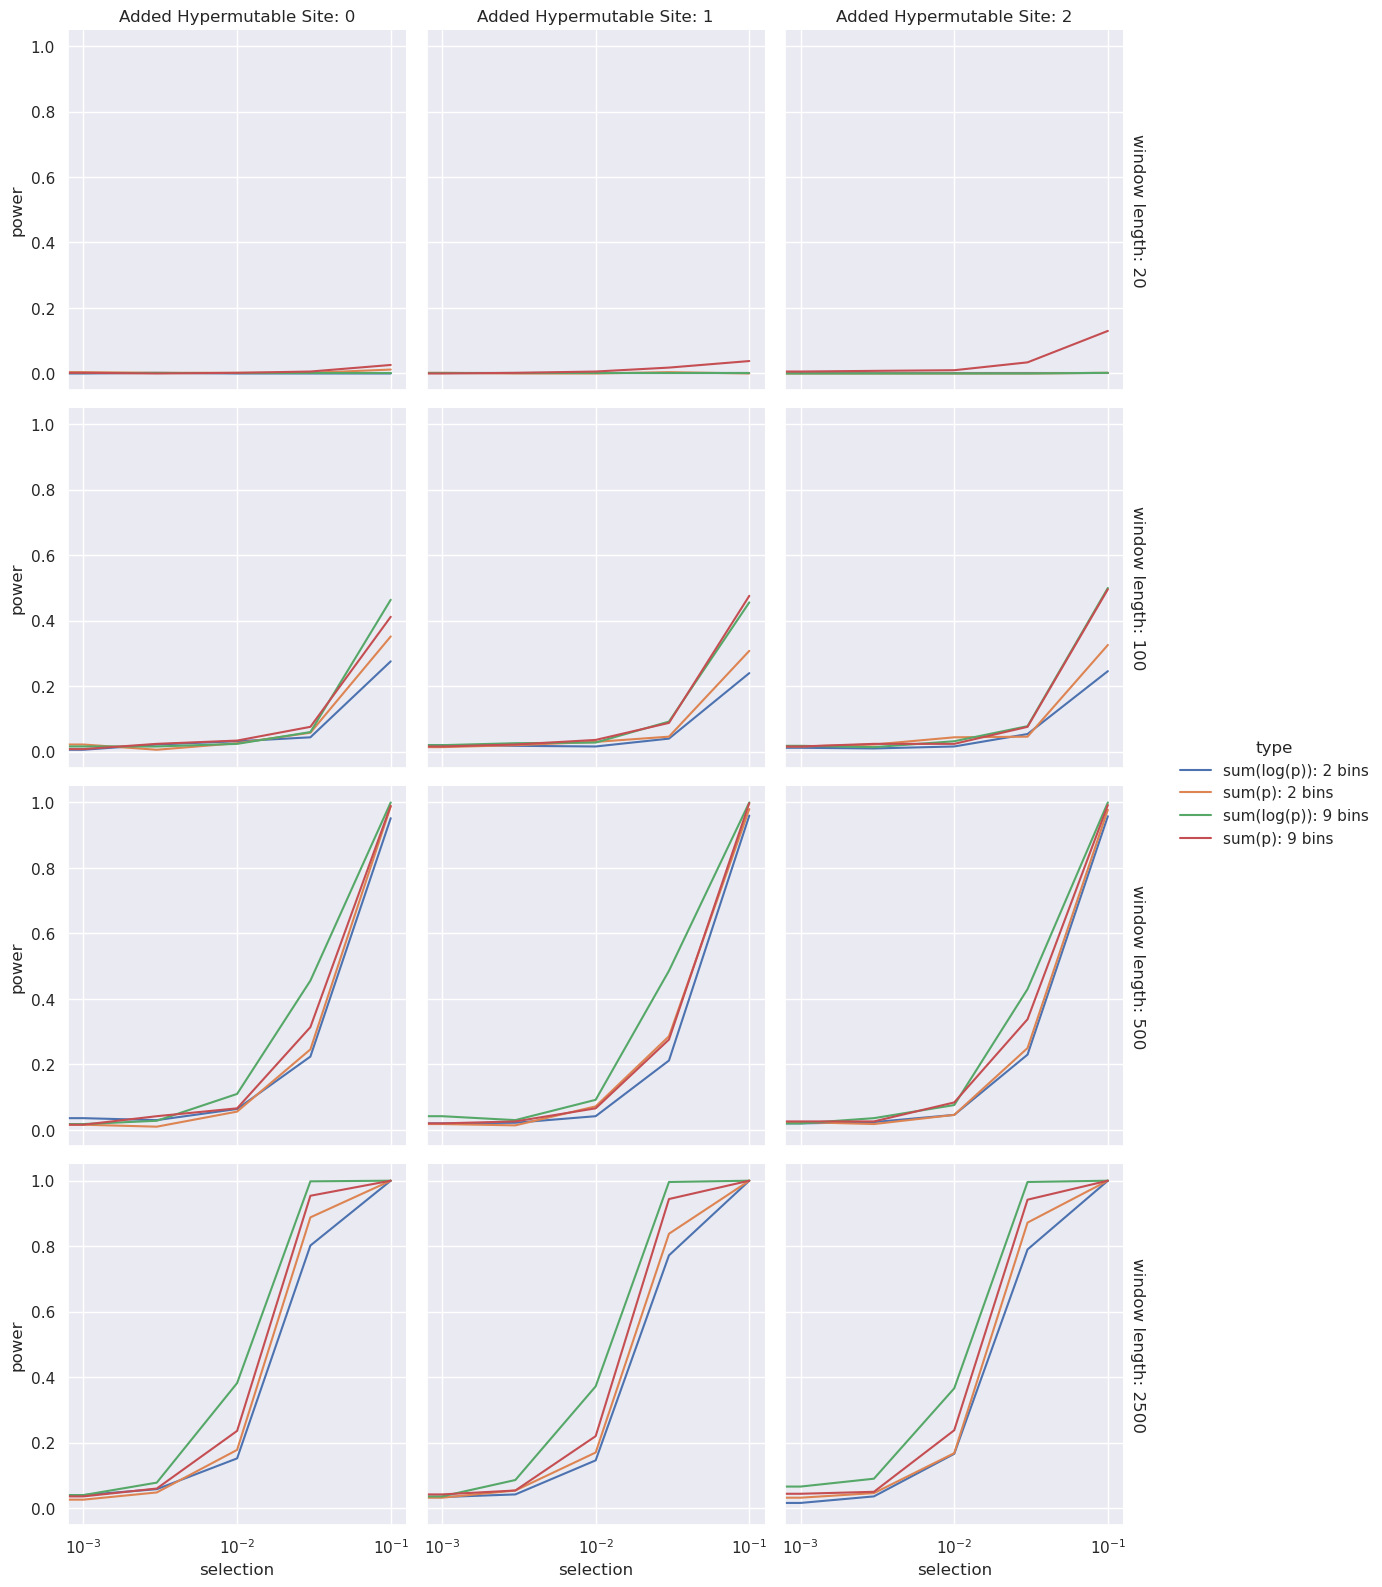

In [9]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="hypermutable_count", row="window length", height=4, margin_titles=True, hue = "type")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="Added Hypermutable Site: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength_hypermutable.svg", format="svg", bbox_inches="tight")